This notebook contains the code to reproduce the plots used for analysis of our model predictions: comparison against GEO-TREES experimental plots (Schepaschenko et al. 2019) and the satellite-based model from Walker et al. (2022). Code from this notebook reproduces Figs.5-6 and Table 1 from the main text, and SM.2-4.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path


Get the datafiles needded for the analysis.

In [2]:
from data import fetch_geo_trees_data, fetch_walker_agcd_map, fetch_ecoregion_data

geo_trees = fetch_geo_trees_data()
walker_agcd_map = fetch_walker_agcd_map()
ecoregion_data = fetch_ecoregion_data()
climate_envelope_map = "./data/prediction/potential_AGBD_Mgha_1km2_contemporary_climate.tif"

The map derived from the satellite-based model of Walker et al. (2022) is in a different projection and stores Aboveground Carbon Density (AGCD) information instead of Aboveground Biomass Density (AGBD). A conversion factor of 2 to transform AGCD to AGBD is widely used accross the literature and therefore we re-scaled the AGCD map with this factor before comparing with our predictions.


In [3]:
from geoutils import rescale_raster, reproject_raster

carbon_to_biomass_factor = 2

savedir = str(Path(walker_agcd_map).parents[0])

# First re-scale
savepath = savedir + "/Base_Pot_AGBD_Mgha_500m.tif"
if not Path(savepath).exists():
    walker2022_agbd_map = rescale_raster(carbon_to_biomass_factor,walker_agcd_map,savepath)
else:
    walker2022_agbd_map = savepath 

# Then reproject to WGS84 EPSG:4326.
savepath = savedir + "/Base_Pot_AGBD_Mgha_500m_WGS84_EPSG_4326.tif"
if not Path(savepath).exists():
    walker2022_agbd_WGS84_map = reproject_raster("EPSG:4326",walker2022_agbd_map,savepath)
else:
    walker2022_agbd_WGS84_map = savepath 

In the next cell we process the data from GEO-TREES experimental plots. We take as final AGBD value the average of estimations with local allometries, Chave et al. (2014) pan-tropical allometry and Feldspauch allometry. 

In [4]:
# TODO: the downloaded excel file cannot be opened with PANDAS. Unsure why.
df = pd.read_csv("data/validation/geo_trees_data/FOS_Plots_v2019.04.10.csv")

# Columns of interest for the analysis.
columns = ["Lat_cnt","Lon_cnt","AGB_local","AGB_Feldpausch","AGB_Chave","AGB_Feldpausch_Cred_2.5","AGB_ChaveCred_2.5", "AGB_local_Cred_2.5", "AGB_Feldpausch_Cred_97.5", "AGB_ChaveCred_97.5", "AGB_local_97.5"]

df = df[columns]

df["geometry"] = list(zip(df.Lat_cnt, df.Lon_cnt))

# Estimate AGBD as the average from mulitple estimations based on different allometries.
df = df.assign(AGB_mean=df[["AGB_local","AGB_Feldpausch","AGB_Chave"]].mean(axis=1))

# Repeat the same procedure for the confidence intervals.
df = df.assign(AGB_lowCI_mean=df[["AGB_local_Cred_2.5","AGB_Feldpausch_Cred_2.5","AGB_ChaveCred_2.5"]].mean(axis=1))
df = df.assign(AGB_highCI_mean=df[["AGB_local_97.5","AGB_Feldpausch_Cred_97.5","AGB_ChaveCred_97.5"]].mean(axis=1))

# Keep only the relevant columns.
df = df[ ["geometry","AGB_mean","AGB_lowCI_mean","AGB_highCI_mean","Lat_cnt","Lon_cnt"] ]
df = df.reset_index()

# TODO: check why I wanted geometry before.
df = df[ ["AGB_mean","AGB_lowCI_mean","AGB_highCI_mean","Lat_cnt","Lon_cnt"] ]

# Build the GeoDataFrame.
gdf = gpd.GeoDataFrame(
        df,
        geometry= gpd.points_from_xy(x=df.Lon_cnt, y=df.Lat_cnt)
    )
gdf.crs = "EPSG:4326"

# Remove null values.
geotrees = gdf[gdf["AGB_mean"]>0.0]

geotrees.to_file("./data/validation/geo_trees_data/geotrees_processed.shp",driver="ESRI Shapefile")


/tmp/ipykernel_10464/652422865.py:35: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geotrees.to_file("./data/validation/geo_trees_data/geotrees_processed.shp",driver="ESRI Shapefile")


Add biome and realm information to the GEO-TREES dataframe and include AGBD estimations from our model and the satellite-based one. Finally, calculate Absolute Percentage Errors in each GEO-TREES plot.

In [5]:
from geoutils import add_feature

geotrees = add_feature(geotrees,"BIOME_NAME",ecoregion_data,"Biome")
geotrees = add_feature(geotrees,"REALM",ecoregion_data,"Realm")
geotrees = add_feature(geotrees,"agbd_CE",climate_envelope_map)
geotrees = add_feature(geotrees,"agbd_WK",walker2022_agbd_WGS84_map)

geotrees["APE CE-Model"] = np.abs(geotrees["agbd_CE"] - geotrees["AGB_mean"])/geotrees["AGB_mean"]*100
geotrees["APE WK-Model"] = np.abs(geotrees["agbd_WK"] - geotrees["AGB_mean"])/geotrees["AGB_mean"]*100

ape_ce = geotrees[["APE CE-Model","Realm","Biome"]].rename(columns={"APE CE-Model":"APE"})
ape_ce["Source"] = "CE-Model"
ape_wk = geotrees[["APE WK-Model","Realm","Biome"]].rename(columns={"APE WK-Model":"APE"})
ape_wk["Source"] = "WK-Model"
ape = pd.concat([ape_ce,ape_wk],ignore_index=True)

/home/dibepa/miniforge3/envs/agbd/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Plot the distribution of Absolute Percentage Errors of our model and the satellite-based model at biome and realm level. (Figure 5. in the main text and SM )

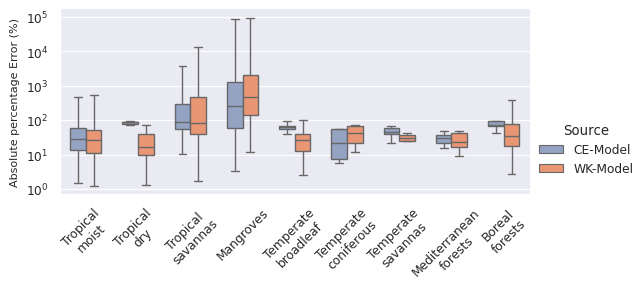

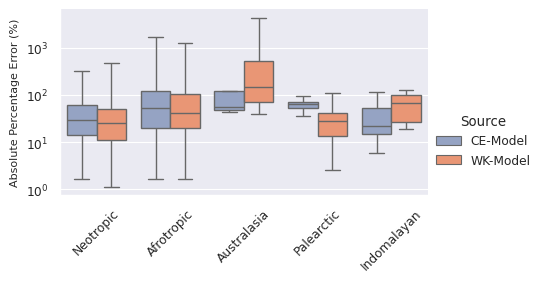

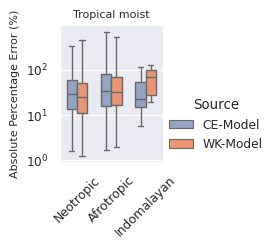

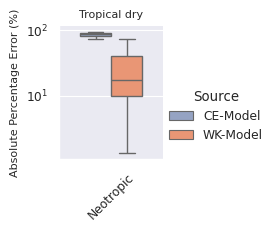

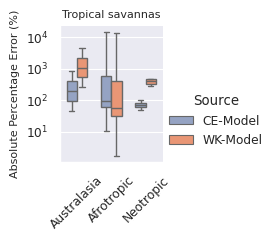

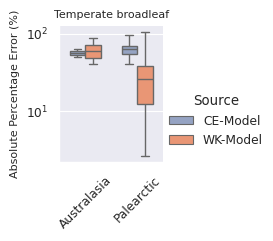

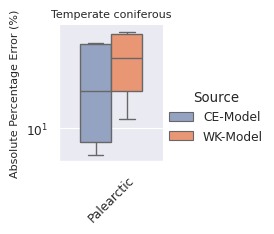

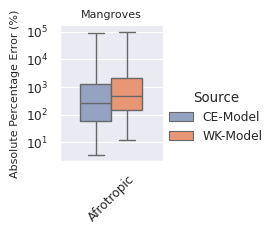

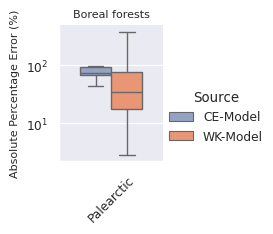

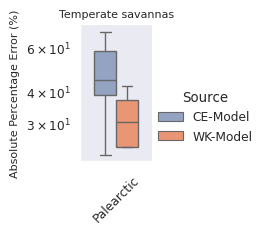

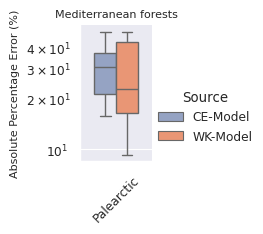

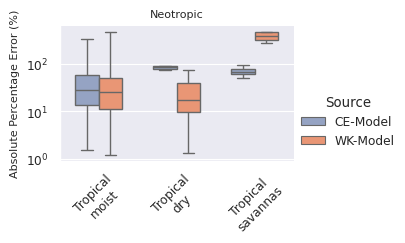

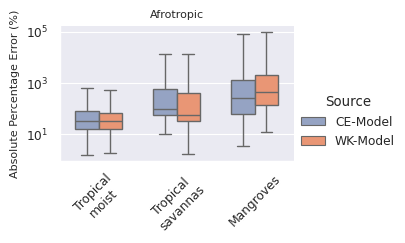

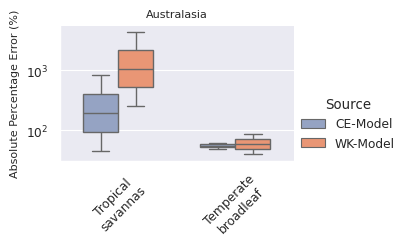

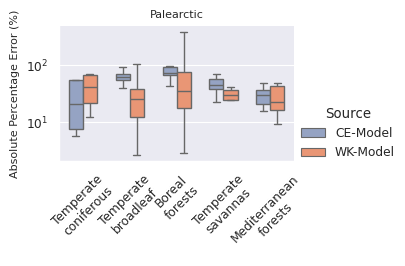

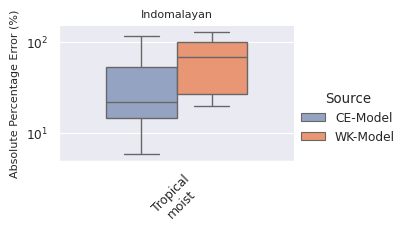

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
import textwrap

sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})
sns.set_style("darkgrid")

savedir = "./figures/"

def shorten_biome_names(biome):
     match biome:
          case "Tropical & Subtropical Moist Broadleaf Forests":
               return "Tropical moist"
          case "Tropical & Subtropical Dry Broadleaf Forests":
               return "Tropical dry"
          case "Tropical & Subtropical Grasslands, Savannas & Shrublands":
               return "Tropical savannas"
          case "Tropical & Subtropical Coniferous Forests":
               return "Tropical coniferous"
          case "Mangroves":
               return "Mangroves"
          case "Flooded Grasslands & Savannas":
               return "Flooded savannas"
          case "Temperate Broadleaf & Mixed Forests":
               return "Temperate broadleaf"
          case "Temperate Conifer Forests":
               return "Temperate coniferous"
          case "Temperate Grasslands, Savannas & Shrublands":
               return "Temperate savannas"
          case "Mediterranean Forests, Woodlands & Scrub":
               return "Mediterranean forests"
          case "Deserts & Xeric Shrublands":
               return "Deserts"
          case "Boreal Forests/Taiga":
               return "Boreal forests"
          case "Tundra":
               return "Tundra"
          case "Montane Grasslands & Shrublands":
               return "Montane grasslands"           
          
ape["Biome_short"] = ape["Biome"].apply(lambda name: shorten_biome_names(name))

order = [
        "Tropical moist",
        "Tropical dry",
        "Tropical savannas",
        "Mangroves",
        "Temperate broadleaf", 
        "Temperate coniferous",
        "Temperate savannas",
        "Mediterranean forests",
        "Boreal forests",
    ]  

g = sns.catplot(
    ape,y="APE",x="Biome_short",
    kind="box",
    hue="Source",
    hue_order=['CE-Model','WK-Model'],
    palette=["#8da0cb","#fc8d62"],
    order=order,
    aspect=2.2,height=2.5,width = 0.6,
    showfliers = False,
    log_scale=True
)

g.set(ylabel="Absolute percentage Error (%)",xlabel="")
labels = [textwrap.fill(label.get_text(), 8, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
g.set_xticklabels(labels)
g.set_xticklabels(rotation=45)
plt.savefig("{}validation_geotreees_biomes_300dpi.png".format(savedir),dpi=300)
plt.savefig("{}validation_geotreees_biomes.svg".format(savedir))
plt.show()

g = sns.catplot(
    ape,y="APE",x="Realm",
    kind="box",
    hue="Source",
    hue_order=['CE-Model','WK-Model'],
    palette=["#8da0cb","#fc8d62"],
    # order=order,
    aspect=1.8,height=2.5,
    showfliers = False,
    log_scale=True
)

g.set(ylabel="Absolute Percentage Error (%)",xlabel="")
labels = [textwrap.fill(label.get_text(), 8, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
g.set_xticklabels(labels)
g.set_xticklabels(rotation=45)
plt.savefig("{}validation_geotreees_realms_300dpi.png".format(savedir),dpi=300)
plt.savefig("{}validation_geotreees_realms.svg".format(savedir))
plt.show()

for biome in ape["Biome_short"].unique():
    df = ape[ape["Biome_short"]==biome]
    g = sns.catplot(
        df,y="APE",x="Realm",
        kind="box",
        hue="Source",
        hue_order=['CE-Model','WK-Model'],
        palette=["#8da0cb","#fc8d62"],
        # order=order,
        aspect=1.0,height=2.,
        showfliers = False,
        log_scale=True,
        **{"width":0.6}
    )
    g.set(ylabel="Absolute Percentage Error (%)",xlabel="",title=biome)
    labels = [textwrap.fill(label.get_text(), 8, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
    g.set_xticklabels(labels)
    g.set_xticklabels(rotation=45)
    plt.savefig("{}validation_geotreees_biome_{}.png".format(savedir,biome),dpi=300)
    plt.savefig("{}validation_geotreees_biome_{}.svg".format(savedir,biome))
    plt.show()

for realm in ape["Realm"].unique():
    df = ape[ape["Realm"]==realm]
    g = sns.catplot(
        df,y="APE",x="Biome_short",
        kind="box",
        hue="Source",
        hue_order=['CE-Model','WK-Model'],
        palette=["#8da0cb","#fc8d62"],
        # order=order,
        aspect=1.6,height=2.,
        showfliers = False,
        log_scale=True,
        **{"width":0.6}
    )
    g.set(ylabel="Absolute Percentage Error (%)",xlabel="",title=realm)
    labels = [textwrap.fill(label.get_text(), 8, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
    g.set_xticklabels(labels)
    g.set_xticklabels(rotation=45)
    plt.savefig("{}validation_geotreees_realm_{}.png".format(savedir,realm),dpi=300)
    plt.savefig("{}validation_geotreees_realm_{}.svg".format(savedir,realm))
    plt.show()    

We compare the predictions from our tree-based, parsimonious climate-envelope model and the satellite-based benchmark model (Walker et al., 2022) at the realm, biome and ecoregion level. To reduce the computational load we perform this analysis in downsampled rasters at a resolution of 10km (original resolution: 1km and 500m for our prediction and the satellite-based one respectively). Downsampling is carried over in the next cell: 

In [8]:
from geoutils import downsample_raster

target_resolution = 0.083333 # 10km in degrees

savedir = str(Path(walker_agcd_map).parents[0])
savepath = savedir + "/Base_Pot_AGBD_Mgha_WGS84_EPSG_4326_10km.tif" 

if not Path(savepath).exists():
    walker2022_downsampled = downsample_raster(target_resolution, walker2022_agbd_WGS84_map, savepath)
else:
    walker2022_downsampled = savepath

savedir = str(Path(climate_envelope_map).parents[0])
savepath = savedir + "/potential_AGBD_Mgha_10km2_present_conditions.tif" 

if not Path(savepath).exists():
    ce2024_downsampled = downsample_raster(target_resolution, climate_envelope_map, savepath)
else:
    ce2024_downsampled = savepath

Collect information of model predictions, ecoregion, biome and biogeographical realm in a unique dataframe. 

In [13]:
from geoutils import vectorize_raster_layer_to_points

# Create a point layer from the climate envelope map.
agbd_comparison = vectorize_raster_layer_to_points(ce2024_downsampled,"AGBD_CE")
# Remove nodata values.
agbd_comparison = agbd_comparison[agbd_comparison["AGBD_CE"]>-9999]
# Add values from Walker et al. (2022) map by sampling with the point layer.
agbd_comparison = add_feature(agbd_comparison,"AGBD_WK",walker2022_downsampled,"AGBD_WK","uint16")
# Add biome and ecoregion information.
agbd_comparison = add_feature(agbd_comparison,"BIOME_NAME",ecoregion_data,"Biome")
agbd_comparison = add_feature(agbd_comparison,"ECO_NAME",ecoregion_data,"Ecoregion")
agbd_comparison = add_feature(agbd_comparison,"REALM",ecoregion_data,"Realm")

savepath = "./data/validation/AGBD_comparison_CE_WK_biome_ecoregion_realm.csv"
if not Path(savepath).exists():
    agbd_comparison.to_csv(savepath,index=False)


Format the dataframe to produce box plots with biome and realm level comparisons.

In [5]:
# TODO: This could probably be done in a more Pythonic way by using a pivot_table function.
agbd_comparison_ce = agbd_comparison.drop(columns="AGBD_WK")
agbd_comparison_ce["Source"] = "CE-Model"
agbd_comparison_ce = agbd_comparison_ce.rename(columns={"AGBD_CE":"AGBD"})
agbd_comparison_wk = agbd_comparison.drop(columns="AGBD_CE")
agbd_comparison_wk["Source"] = "WK-Model"
agbd_comparison_wk = agbd_comparison_wk.rename(columns={"AGBD_WK":"AGBD"})

agbd_comparison_biome_realm = pd.concat([agbd_comparison_ce,agbd_comparison_wk],axis="rows")

In [8]:
import seaborn as sns
from matplotlib import pyplot as plt
import textwrap
def shorten_biome_names(biome):
     match biome:
          case "Tropical & Subtropical Moist Broadleaf Forests":
               return "Tropical moist"
          case "Tropical & Subtropical Dry Broadleaf Forests":
               return "Tropical dry"
          case "Tropical & Subtropical Grasslands, Savannas & Shrublands":
               return "Tropical savannas"
          case "Tropical & Subtropical Coniferous Forests":
               return "Tropical coniferous"
          case "Mangroves":
               return "Mangroves"
          case "Flooded Grasslands & Savannas":
               return "Flooded savannas"
          case "Temperate Broadleaf & Mixed Forests":
               return "Temperate broadleaf"
          case "Temperate Conifer Forests":
               return "Temperate coniferous"
          case "Temperate Grasslands, Savannas & Shrublands":
               return "Temperate savannas"
          case "Mediterranean Forests, Woodlands & Scrub":
               return "Mediterranean forests"
          case "Deserts & Xeric Shrublands":
               return "Deserts"
          case "Boreal Forests/Taiga":
               return "Boreal forests"
          case "Tundra":
               return "Tundra"
          case "Montane Grasslands & Shrublands":
               return "Montane grasslands"  

Create the plots for biome-level and realm-level comparison of our prediction and the satellite-based ones.

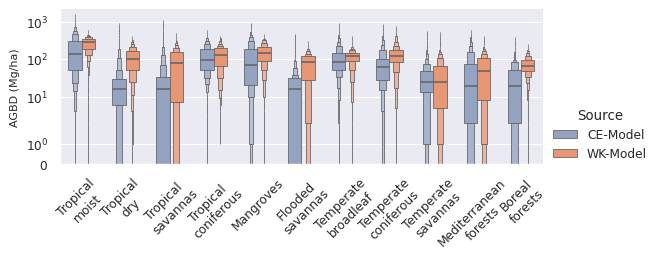

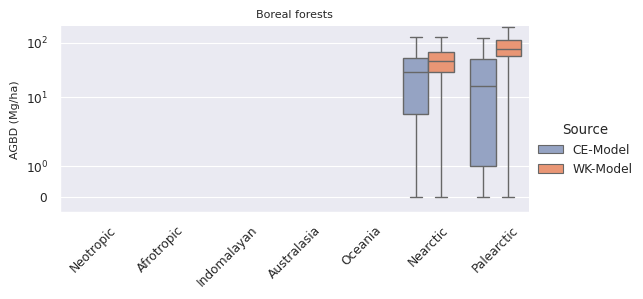

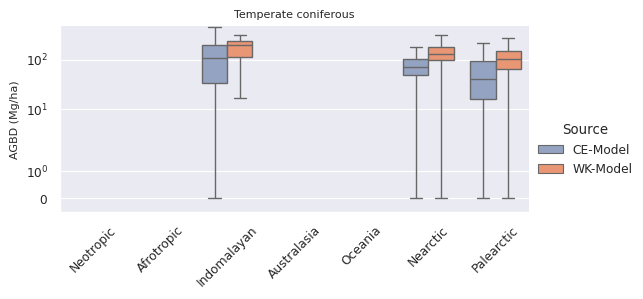

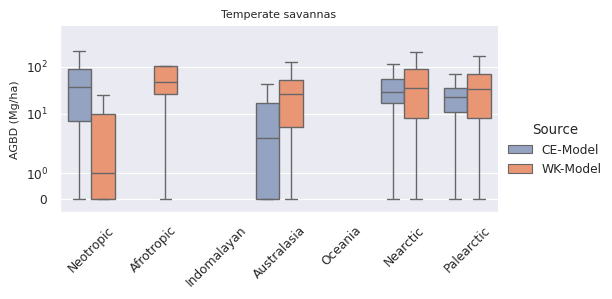

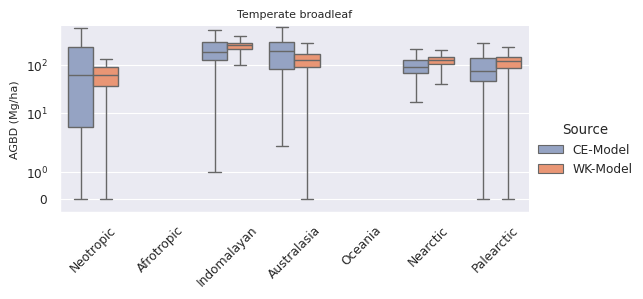

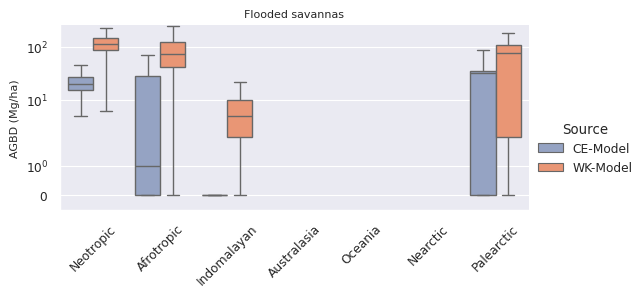

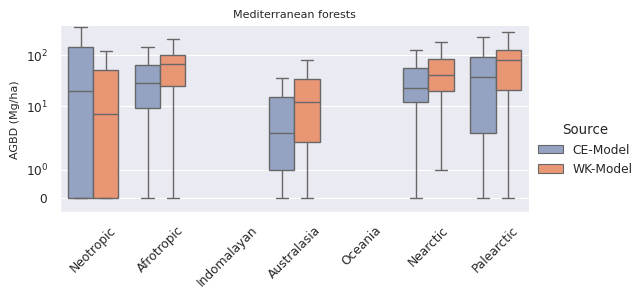

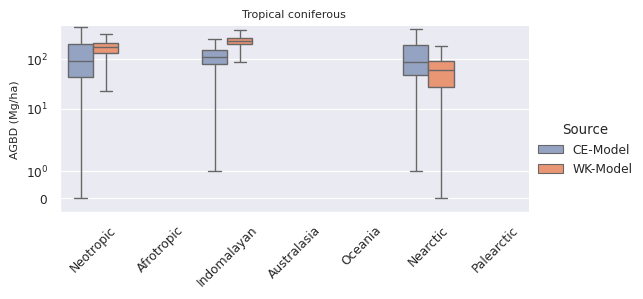

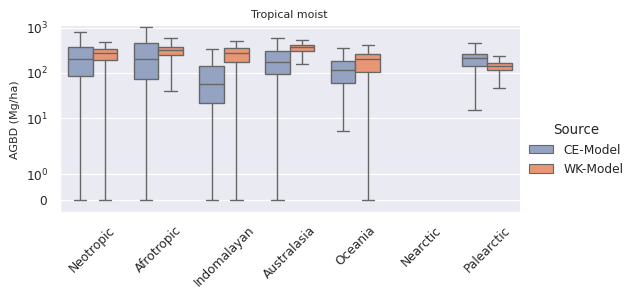

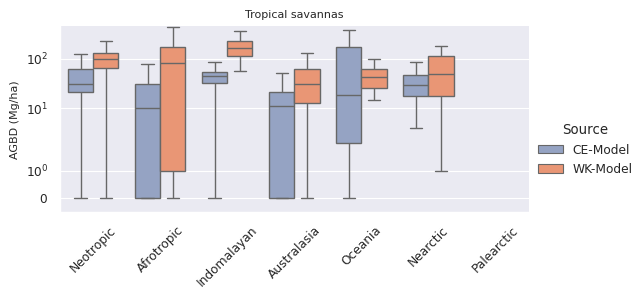

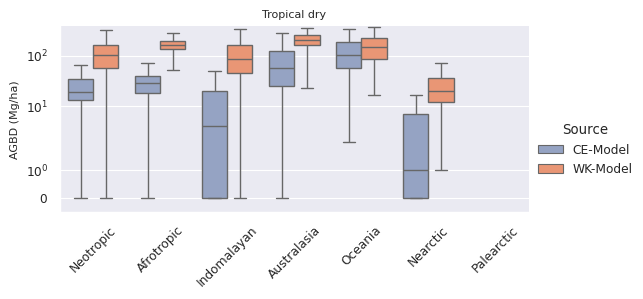

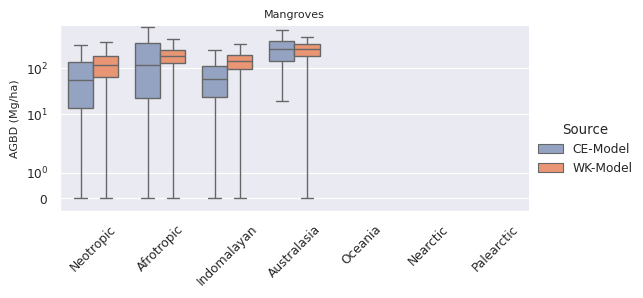

In [11]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})
sns.set_style("darkgrid")
savedir = "./figures/"      

# Shorten biome names for readability.
agbd_comparison_biome_realm["Biome_short"] = agbd_comparison_biome_realm["Biome"].apply(lambda name: shorten_biome_names(name))

# Set the box-plotting order and remove biomes without woody vegetation: Deserts, Tundra, Montane Grasslands.
order = [
        "Tropical moist",
        "Tropical dry",
        "Tropical savannas",
        "Tropical coniferous",
        "Mangroves",
        "Flooded savannas",
        "Temperate broadleaf", 
        "Temperate coniferous",
        "Temperate savannas",
        "Mediterranean forests",
        "Boreal forests",
    ]  
mask = agbd_comparison_biome_realm["Biome_short"].isin(order)
agbd_comparison_filtered = agbd_comparison_biome_realm[mask]

# Create the biome-level plot (Figure 6. in the manuscript's main text)
g = sns.catplot(
    data=agbd_comparison_filtered,x="Biome_short",y="AGBD",
    kind="boxen",
    hue="Source",
    hue_order=['CE-Model','WK-Model'],
    legend=True,
    aspect=2.7,height=2.2,
    palette=["#8da0cb","#fc8d62",],
    gap=.0, width_method = "exponential", k_depth="trustworthy", width=.6,
    showfliers=False,
    order= order,
    line_kws={"linewidth":1.2}
)

g.set(ylabel="AGBD (Mg/ha)",xlabel="",ylim=(0.0,None))
g.set(yscale="symlog")
labels = [textwrap.fill(label.get_text(), 8, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
g.set_xticklabels(labels)
g.set_xticklabels(rotation=45)
plt.savefig("{}agbd_biome_vs_walker_300dpi.png".format(savedir),dpi=300,bbox_inches = "tight")
plt.savefig("{}agbd_biome_vs_walker.svg".format(savedir))
plt.show()

order_realm = [
    "Neotropic",
    "Afrotropic",
    "Indomalayan",
    "Australasia",
    "Oceania",
    "Nearctic",
    "Palearctic",
]

def filter_realms(df):
    realm_list = []
    for realm in df['Realm'].unique():
        df_filt = df[ df['Realm'] == realm ]
        if len(df_filt.Source.unique())==3:
            realm_list.append(realm)
    mask = df['Realm'].isin(realm_list)
    df_filt = df[mask]        
    return df_filt, realm_list        

for biome in agbd_comparison_filtered["Biome_short"].unique():

    df = agbd_comparison_filtered[agbd_comparison_filtered["Biome_short"]==biome]

    try:
        g = sns.catplot(
            data=df,x="Realm",y="AGBD",
            kind="box",
            hue="Source",
            hue_order=['CE-Model','WK-Model'],
            legend=True,
            aspect=2.2,height=2.5,
            palette=["#8da0cb","#fc8d62",],
           # gap=.1, #width_method = "exponential", k_depth="trustworthy", width=.8, # Parameters for boxen plot.
            showfliers=False,
            order= order_realm,
            **{'width' : 0.75},
            # line_kws={"linewidth":2.0} # Parameter for boxen plot.
        )
        g.set(ylabel="AGBD (Mg/ha)",xlabel="")
        g.set(yscale="symlog",title=biome,ylim=[-0.5,None])
        labels = [textwrap.fill(label.get_text(), 8, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
        g.set_xticklabels(labels)
        g.set_xticklabels(rotation=45)

        plt.savefig("{}agbd_realm_biome_{}_vs_walker300dpi.png".format(savedir,biome),dpi=300,bbox_inches = "tight")
        plt.savefig("{}agbd_realm_biome_{}_vs_walker.svg".format(savedir,biome))

        plt.show()
    except: 
        continue

Calculate median ecoregion AGBD values for our model and the satellite-based benchmark.

In [22]:
agbd_comparison_ecoregion = agbd_comparison[["AGBD_WK","AGBD_CE","Biome","Ecoregion","Realm"]].groupby("Ecoregion").agg(
    {"AGBD_CE":"median", "AGBD_WK":"median", "Biome":"first", "Realm":"first"}
)

Group biomes in broader classes (e.g. tropical moist -> tropical) and store information on the subclass (e.g. tropical moist -> moist).

In [23]:

def group_biome_short(biome):
     match biome:
          case "Tropical moist":
               return"Tropical"
          case "Tropical dry":
               return "Tropical"
          case "Tropical coniferous":
               return "Tropical"
          case "Tropical savannas":
               return "Tropical"
          case "Mangroves":
               return "Tropical"
          case "Flooded savannas":
               return "Flooded savannas"
          case "Temperate broadleaf":
               return "Temperate"
          case "Temperate coniferous":
               return "Temperate"
          case "Temperate savannas":
               return "Temperate"
          case "Mediterranean forests":
               return "Mediterranean forests"
          case "Boreal forests":
               return "Boreal forests"
          case "Deserts":
               return "Deserts and Tundra"
          case "Tundra":
               return "Deserts and Tundra"
          case "Montane grasslands":
               return "Montane grasslands"
         
def biome_subclass(biome):
     match biome:           
          case "Tropical moist":
               return"Moist"
          case "Tropical dry":
               return "Dry"
          case "Tropical coniferous":
               return "Coniferous"
          case "Tropical savannas":
               return "Savannas"
          case "Mangroves":
               return "Mangroves"
          case "Flooded savannas":
               return "Flooded savannas"
          case "Temperate broadleaf":
               return "Broadleaf"
          case "Temperate coniferous":
               return "Coniferous"
          case "Temperate savannas":
               return "Savannas"
          case "Mediterranean forests":
               return "Mediterranean forests"
          case "Boreal forests":
               return "Boreal forests"
          case "Deserts":
               return "Deserts and Tundra"
          case "Tundra":
               return "Deserts and Tundra"
          case "Montane grasslands":
               return "Montane grasslands" 
          
agbd_comparison_ecoregion["Biome_short"] = agbd_comparison_ecoregion["Biome"].apply(lambda x: shorten_biome_names(x))
agbd_comparison_ecoregion["Biome_short_grouped"] = agbd_comparison_ecoregion["Biome_short"].apply(lambda x: group_biome_short(x))
agbd_comparison_ecoregion["Biome_short_grouped_subclass"] = agbd_comparison_ecoregion["Biome_short"].apply(lambda x: biome_subclass(x))         

Plot the ecoregion-level comparison with the satellite-based model. 

Realm: Australasia


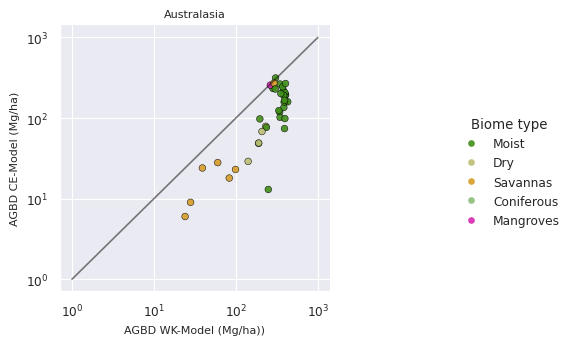

Realm: Afrotropic


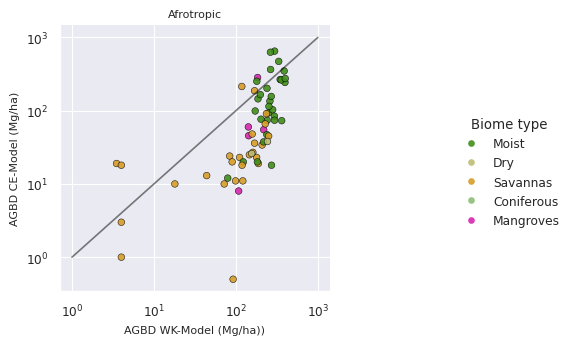

Realm: Neotropic


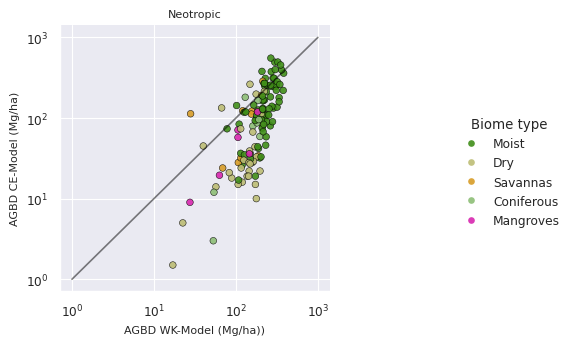

Realm: Indomalayan


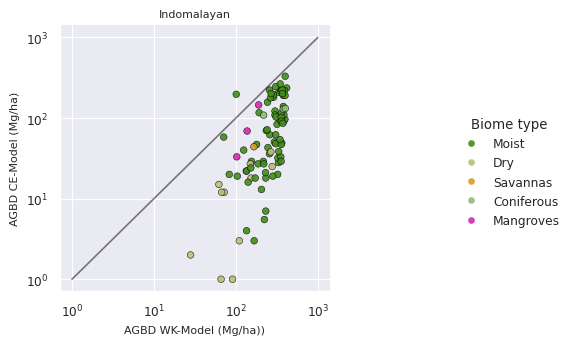

Realm: Nearctic


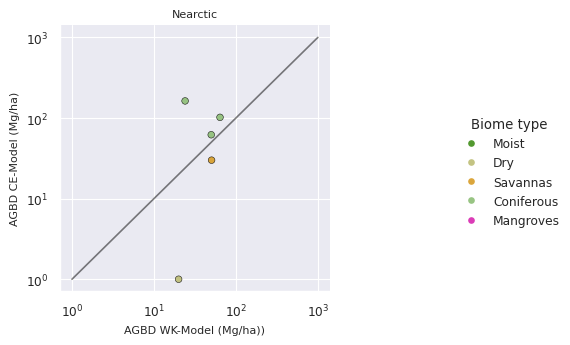

Realm: Oceania


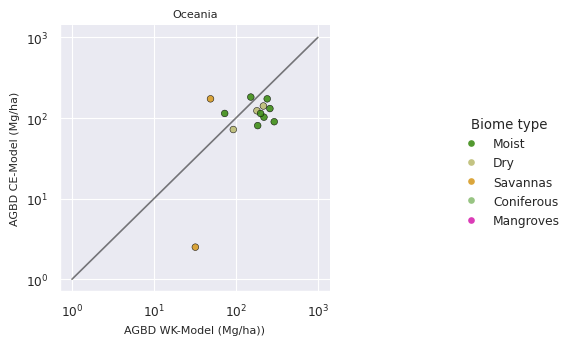

Realm: Palearctic


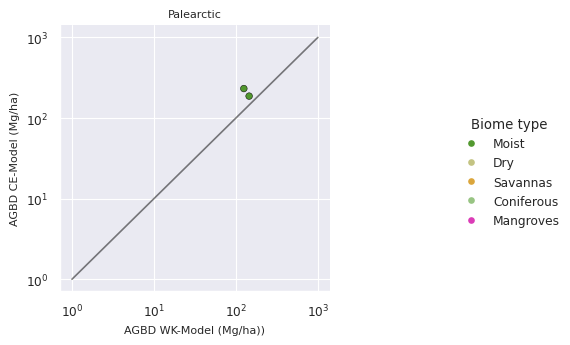

Realm: Palearctic


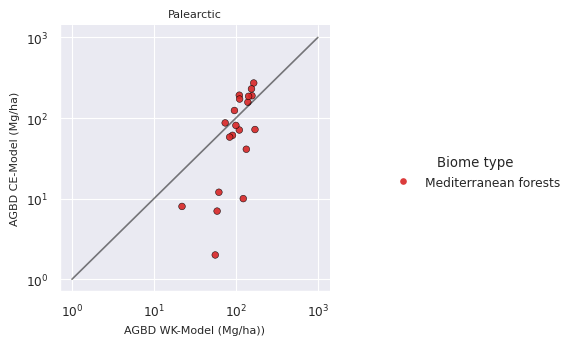

Realm: Afrotropic


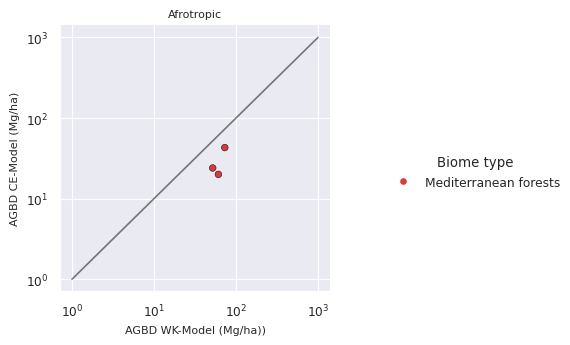

Realm: Nearctic


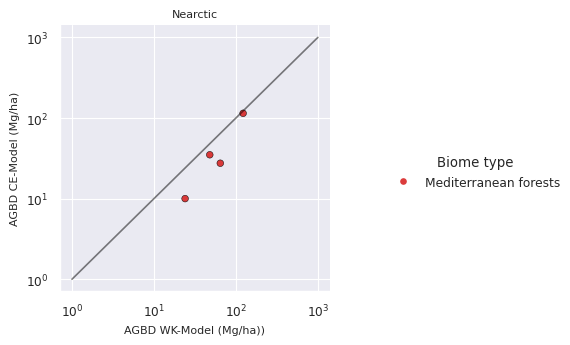

Realm: Neotropic


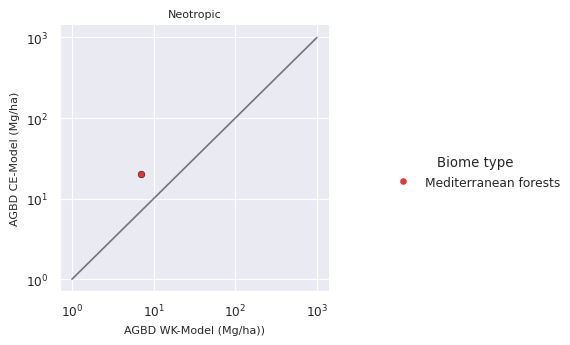

Realm: Australasia


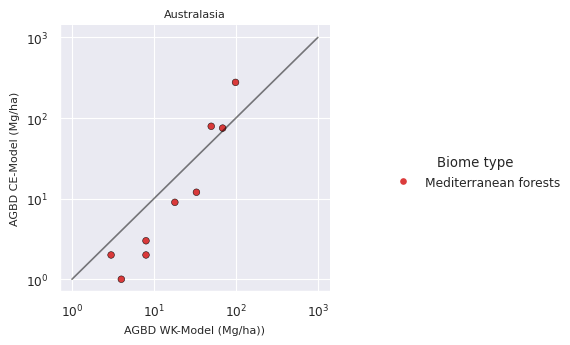

Realm: Palearctic
Realm: Nearctic
Realm: Afrotropic
Realm: Australasia
Realm: Indomalayan
Realm: Neotropic
Realm: Palearctic


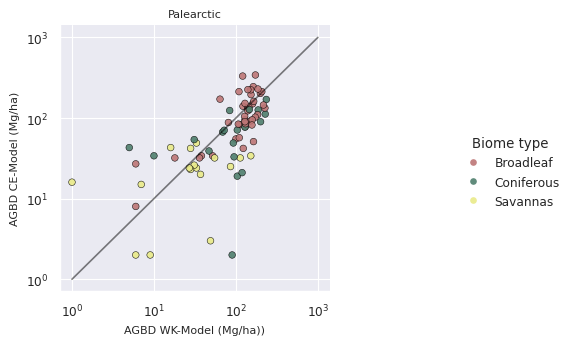

Realm: Nearctic


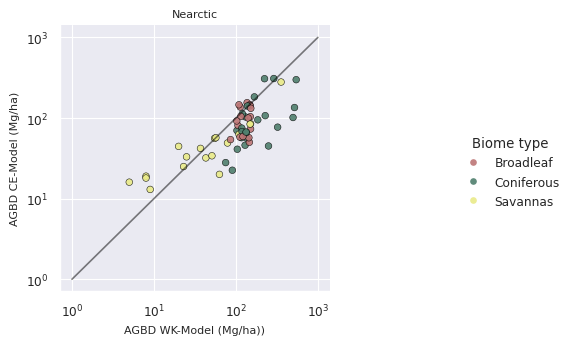

Realm: Australasia


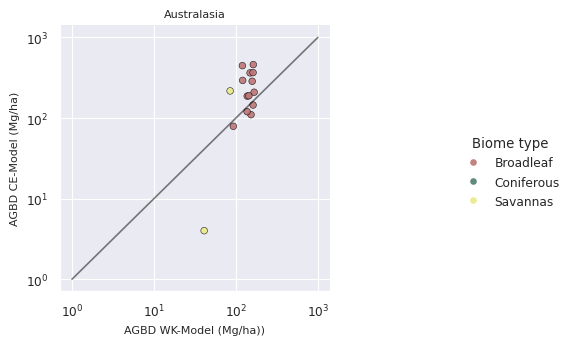

Realm: Indomalayan


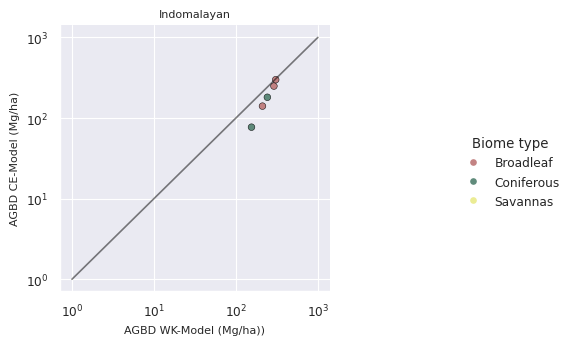

Realm: Neotropic


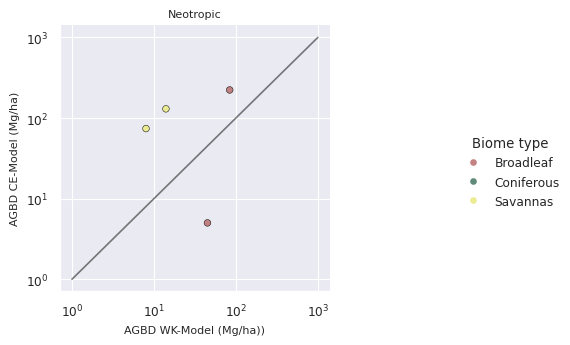

Realm: Nearctic


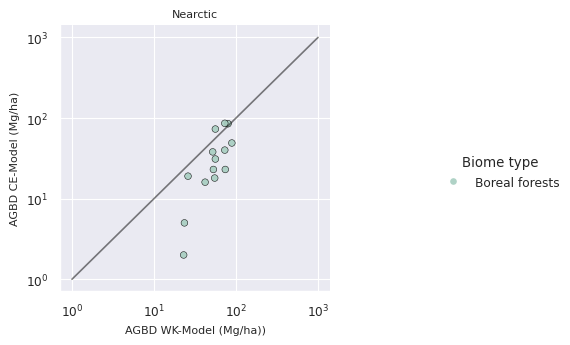

Realm: Palearctic


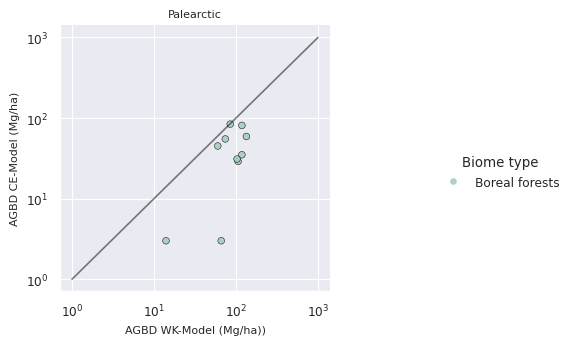

Realm: Palearctic
Realm: Afrotropic
Realm: Australasia
Realm: Neotropic
Realm: Indomalayan
Realm: Palearctic
Realm: Neotropic
Realm: Afrotropic
Realm: Indomalayan


In [24]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})
sns.set_style("darkgrid")

savedir = "./figures/"
if not Path(savedir).exists():
     Path(savedir).mkdir(parents=True)

# Extract color codes from the WWF ecoregions polygon layer.
biome_color = gpd.read_file(ecoregion_data).groupby(by="BIOME_NAME").agg({"COLOR_BIO":"first"})
# Biome order for plotting.
biome_order = [
    "Tropical & Subtropical Moist Broadleaf Forests",
    "Tropical & Subtropical Dry Broadleaf Forests",
    "Tropical & Subtropical Grasslands, Savannas & Shrublands",
    "Tropical & Subtropical Coniferous Forests",
    "Mangroves",
    "Flooded Grasslands & Savannas",
    "Temperate Broadleaf & Mixed Forests", 
    "Temperate Conifer Forests",
    "Temperate Grasslands, Savannas & Shrublands",
    "Mediterranean Forests, Woodlands & Scrub",
    "Deserts & Xeric Shrublands",
    "Boreal Forests/Taiga",
    "Tundra",
    "Montane Grasslands & Shrublands"
]
biome_color = biome_color.reindex(biome_order).reset_index()
# De-saturate palette
palette = sns.color_palette( palette = biome_color["COLOR_BIO"], desat=0.7)
# Create palette for specific biomes within broader forest type: Tropical, Mediterranean, Temperate, Boreal.
palettes = {
    "Tropical" : (sns.color_palette([palette[0],palette[1],palette[2],palette[3],palette[4]]), ["Moist","Dry","Savannas","Coniferous","Mangroves"]),
     "Mediterranean forests" : (sns.color_palette([palette[9]]), ["Mediterranean forests"]),
     "Temperate" : (sns.color_palette([palette[10],palette[7],palette[8]]), ["Broadleaf","Coniferous","Savannas"]),
     "Boreal forests": (sns.color_palette([palette[12]]), ["Boreal forests"])
}

# Plot for each broader forest type and realm our prediction against the satellite-based one colouring points by biome-type (SM3) .
for biome in agbd_comparison_ecoregion["Biome_short_grouped"].unique():

     df_biome = agbd_comparison_ecoregion[agbd_comparison_ecoregion["Biome_short_grouped"]==biome]

     for realm in df_biome["Realm"].unique():

          df = df_biome[df_biome["Realm"] == realm]     
          try: 
               
               pal,ord = palettes[biome]  
     
               g = sns.relplot(data = df, x="AGBD_WK", y="AGBD_CE", alpha=0.9, hue="Biome_short_grouped_subclass",palette=pal,hue_order=ord,edgecolor="k",height=3.5)
               
               g.set(xscale="log",yscale="log",title=realm,xlabel="AGBD WK-Model (Mg/ha))",ylabel="AGBD CE-Model (Mg/ha)")
               g._legend.set_title("Biome type")
               g.map(sns.lineplot,x=[1,10,100,1000],y=[1,10,100,1000], color="k", alpha = 0.5)
               plt.savefig("{}ecoregion_agbd_comparison_{}_{}_300dpi.png".format(savedir,biome,realm),dpi=300)
               plt.savefig("{}ecoregion_agbd_comparison_{}_{}.svg".format(savedir,biome,realm))
               plt.show()
               
          except:
               continue


Finally compute average AGBD and 99th percentiles across significant world regions (e.g. Amazon, Central African rainforest) in our map and the satellite-based one. The next cell instantiate a dictionary where each broader region is defined as a list of ecoregions.

In [27]:
ecoreg_zone_dict = {
    "Amazon" : ["Tocantins/Pindare moist forests","Xingu-Tocantins-Araguaia moist forests","Tapajós-Xingu moist forests","Madeira-Tapajós moist forests","Purus-Madeira moist forests","Southwest Amazon moist forests","Ucayali moist forests","Purus várzea","Juruá-Purus moist forests","Iquitos várzea","Napo moist forests","Solimões-Japurá moist forests","Caqueta moist forests","Rio Negro campinarana","Negro-Branco moist forests","Guianan piedmont moist forests","Guianan Highlands moist forests","Guianan lowland moist forests","Guianan lowland moist forests","Uatumã-Trombetas moist forests"],

    "Central Africa" : ["Western Guinean lowland forests","Eastern Guinean forests","Nigerian lowland forests","Niger Delta swamp forests","Cross-Niger transition forests","Cameroon Highlands forests","Cross-Sanaga-Bioko coastal forests","Northwest Congolian lowland forests","Congolian coastal forests","Western Congolian swamp forests","Central Congolian lowland forests","Northeast Congolian lowland forests","Albertine Rift montane forests","Northern Congolian Forest-Savanna","Southern Congolian forest-savanna"],
    
    "Asia-Pacific": ["Sri Lanka lowland rain forests","Malabar Coast moist forests","South Western Ghats montane rain forests","South Western Ghats moist deciduous forests","North Western Ghats montane rain forests","North Western Ghats moist deciduous forests","East Deccan moist deciduous forests","Orissa semi-evergreen forests","Himalayan subtropical broadleaf forests","Brahmaputra Valley semi-evergreen forests","Himalayan subtropical pine forests","Meghalaya subtropical forests","Northern Triangle subtropical forests","Mizoram-Manipur-Kachin rain forests","Chin Hills-Arakan Yoma montane forests","Myanmar coastal rain forests","Irrawaddy moist deciduous forests","Yunnan Plateau subtropical evergreen forests","Northern Indochina subtropical forests","Kayah-Karen montane rain forests","Northern Thailand-Laos moist deciduous forests","Chao Phraya freshwater swamp forests","Tenasserim-South Thailand semi-evergreen rain forests","Cardamom Mountains rain forests","Andaman Islands rain forests","Tonle Sap-Mekong peat swamp forests","Tonle Sap freshwater swamp forests","Peninsular Malaysian rain forests","Peninsular Malaysian montane rain forests","Northern Khorat Plateau moist deciduous forests","Northern Vietnam lowland rain forests","Hainan Island monsoon rain forests","South China-Vietnam subtropical evergreen forests","Jian Nan subtropical evergreen forests","Guizhou Plateau broadleaf and mixed forests","Taiwan subtropical evergreen forests","South Taiwan monsoon rain forests","Sumatran montane rain forests","Sumatran peat swamp forests","Mentawai Islands rain forests","Sumatran lowland rain forests","Western Java montane rain forests","Western Java rain forests","Eastern Java-Bali rain forests","Eastern Java-Bali montane rain forests","Borneo montane rain forests","Borneo lowland rain forests","Sundaland heath forests","Southwest Borneo freshwater swamp forests","Palawan rain forests","Sulawesi montane rain forests","Sulawesi lowland rain forests","Seram rain forests","Buru rain forests","Halmahera rain forests","Mindanao-Eastern Visayas rain forests","Greater Negros-Panay rain forests","Mindoro rain forests","Luzon rain forests","Luzon tropical pine forests","Banda Sea Islands moist deciduous forests","Vogelkop montane rain forests","Vogelkop-Aru lowland rain forests","Northern New Guinea lowland rain and freshwater swamp forests","Central Range Papuan montane rain forests","Southern New Guinea lowland rain forests","Southern New Guinea freshwater swamp forests","Northern New Guinea montane rain forests","Southeast Papuan rain forests","Trobriand Islands rain forests","New Britain-New Ireland lowland rain forests","New Britain-New Ireland montane rain forests","Solomon Islands rain forests"],

    "Insular Asia-Pacific" :["Sumatran montane rain forests","Sumatran peat swamp forests","Mentawai Islands rain forests","Sumatran lowland rain forests","Western Java montane rain forests","Western Java rain forests","Eastern Java-Bali rain forests","Eastern Java-Bali montane rain forests","Borneo montane rain forests","Borneo lowland rain forests","Sundaland heath forests","Southwest Borneo freshwater swamp forests","Palawan rain forests","Sulawesi montane rain forests","Sulawesi lowland rain forests","Seram rain forests","Buru rain forests","Halmahera rain forests","Mindanao-Eastern Visayas rain forests","Greater Negros-Panay rain forests","Mindoro rain forests","Luzon rain forests","Luzon tropical pine forests","Banda Sea Islands moist deciduous forests","Vogelkop montane rain forests","Vogelkop-Aru lowland rain forests","Northern New Guinea lowland rain and freshwater swamp forests","Central Range Papuan montane rain forests","Southern New Guinea lowland rain forests","Southern New Guinea freshwater swamp forests","Northern New Guinea montane rain forests","Southeast Papuan rain forests","Trobriand Islands rain forests","New Britain-New Ireland lowland rain forests","New Britain-New Ireland montane rain forests","Solomon Islands rain forests"],

    "Continental Asia-Pacific" :["Sri Lanka lowland rain forests","Malabar Coast moist forests","South Western Ghats montane rain forests","South Western Ghats moist deciduous forests","North Western Ghats montane rain forests","North Western Ghats moist deciduous forests","East Deccan moist deciduous forests","Orissa semi-evergreen forests","Himalayan subtropical broadleaf forests","Brahmaputra Valley semi-evergreen forests","Himalayan subtropical pine forests","Meghalaya subtropical forests","Northern Triangle subtropical forests","Mizoram-Manipur-Kachin rain forests","Chin Hills-Arakan Yoma montane forests","Myanmar coastal rain forests","Irrawaddy moist deciduous forests","Yunnan Plateau subtropical evergreen forests","Northern Indochina subtropical forests","Kayah-Karen montane rain forests","Northern Thailand-Laos moist deciduous forests","Chao Phraya freshwater swamp forests","Tenasserim-South Thailand semi-evergreen rain forests","Cardamom Mountains rain forests","Andaman Islands rain forests","Tonle Sap-Mekong peat swamp forests","Tonle Sap freshwater swamp forests","Peninsular Malaysian rain forests","Peninsular Malaysian montane rain forests","Northern Khorat Plateau moist deciduous forests","Northern Vietnam lowland rain forests","Hainan Island monsoon rain forests","South China-Vietnam subtropical evergreen forests","Jian Nan subtropical evergreen forests","Guizhou Plateau broadleaf and mixed forests","Taiwan subtropical evergreen forests","South Taiwan monsoon rain forests",],

    "Western Europe": ["North Atlantic moist mixed forests","Celtic broadleaf forests","English Lowlands beech forests","Caledon conifer forests","European Atlantic mixed forests","Pyrenees conifer and mixed forests","Cantabrian mixed forests","Western European broadleaf forests","Alps conifer and mixed forests" "Po Basin mixed forests"],
    
    "Central/East Europe" : ["Central European mixed forests","Carpathian montane forests","Pannonian mixed forests","Dinaric Mountains mixed forests","Balkan mixed forests","Rodope montane mixed forests","Baltic mixed forests","Sarmatic mixed forests","Appenine deciduous montane forests","East European forest steppe"],

    "Mediterranean Europe": ["Southwest Iberian Mediterranean sclerophyllous and mixed forests","Iberian sclerophyllous and semi-deciduous forests","Iberian conifer forests","Northeast Spain and Southern France Mediterranean forests","Northwest Iberian montane forests","Italian sclerophyllous and semi-deciduous forests","Tyrrhenian-Adriatic sclerophyllous and mixed forests","Illyrian deciduous forests","Pindus Mountains mixed forests","Aegean and Western Turkey"],

    "Northern Africa" : ["Mediterranean Acacia-Argania dry","Mediterranean woodlands and forests","Mediterranean dry woodlands and steppe","Canary Islands dry woodlands and forests"],

    "Southwest Australia" : ["Southwest Australia savanna","Southwest Australia woodlands","Jarrah-Karri forest and shrublands","Esperance mallee","Coolgardie woodlands","Hampton mallee and woodlands"],

    "Yucatan" : ["Yucatán dry forests"],

    "East african savannas" : ["Dry miombo woodlands","Zambezian-Limpopo mixed woodlands","Zambezian Baikiaea woodlands","Zambezian mopane woodlands","Central Zambezian wet miombo woodlands","Zambezian flooded grasslands","Southern Acacia-Commiphora","Victoria Basin forest-savanna","Northern Acacia-Commiphora bushlands and thickets"],

    "Northamerican Pacific" : ["Northern California coastal forests","Sierra Nevada forests","Klamath-Siskiyou forests","Eastern Cascades forests","Central-Southern Cascades Forests","Central Pacific Northwest coastal forests","Puget lowland forests","British Columbia coastal conifer forests","Queen Charlotte Islands conifer forests","Northern Pacific Alaskan coastal forests"],

    "Uruguay/Argentina savanna": ["Uruguayan savanna","Humid Pampas"],

    "Dry Chaco": ["Dry Chaco"],

    "Chiquitano": ["Chiquitano dry forests"],

    "Northeast Brazil" : ["Maranhão Babaçu forests","Caatinga","Brazilian Atlantic dry forests"],

    "Brazilian Atlantic forests" : ["Araucaria moist forests","Serra do Mar coastal forests","Alto Paraná Atlantic forests","Bahia coastal forests", "Bahia interior forests","Pernambuco coastal forests","Pernambuco interior forests"],

    "Patagonian forests" : ["Valdivian temperate forests","Magellanic subpolar forests"],

    "East Australia" : ["Eastern Australian temperate forests","Southeast Australia temperate forests","Queensland tropical rain forests"],

    "Dry India": ["Narmada Valley dry deciduous forests","Khathiar-Gir dry deciduous forests","Chhota-Nagpur dry deciduous forests","North Deccan dry deciduous forests","Central Deccan Plateau dry deciduous forests","South Deccan Plateau dry deciduous forests","East Deccan dry-evergreen forests"],

    "South Africa" : ["Highveld grasslands","Drakensberg grasslands","Drakensberg Escarpment savanna and thicket","Limpopo lowveld","Central bushveld","Fynbos shrubland","Albany thickets"],

    "Northern Amazonia" : ["Guianan savanna","Llanos"],

    "Indochina/Vietnam" : ["Southern Vietnam lowland dry forests","Southeast Indochina dry evergreen forests","Central Indochina dry forests"],

    "Northern Palearctic" : ["Scandinavian and Russian taiga","West Siberian taiga","East Siberian taiga","Northeast Siberian taiga","Okhotsk-Manchurian taiga","Sakhalin Island taiga","Kamchatka-Kurile meadows and sparse forests"],

    "Northern Nearctic" : ["Interior Alaska-Yukon lowland taiga","Alaska Peninsula montane taiga","Northern Cordillera forests","Muskwa-Slave Lake taiga","Mid-Canada Boreal Plains forests","Midwest Canadian Shield forests","Southern Hudson Bay taiga","Eastern Canadian forests","Eastern Canadian Shield taiga","Central Canadian Shield forests","Northern Canadian Shield taiga","Northwest Territories taiga","Watson Highlands taiga"],

}

In [28]:
ecoregion_df = pd.DataFrame()

model_dict = {"CE-Model" : "AGBD_CE", "WK-Model" : "AGBD_WK"}

def group_biome(biome):
     match biome:
          case "Tropical moist":
               return "Tropical moist"
          case "Tropical dry":
               return "Tropical dry"
          case "Tropical coniferous":
               return "Tropical coniferous"
          case "Tropical savannas":
               return "Grasslands/savannas"
          case "Mangroves":
               return "Tropical"
          case "Flooded savannas":
               return "Flooded savannas"
          case "Temperate broadleaf":
               return "Temperate"
          case "Temperate coniferous":
               return "Temperate"
          case "Temperate savannas":
               return "Grasslands/savannas"
          case "Mediterranean forests":
               return "Mediterranean forests"
          case "Boreal forests":
               return "Boreal forests"
          case "Deserts":
               return "Deserts and Tundra"
          case "Tundra":
               return "Deserts and Tundra"
          case "Montane grasslands":
               return "Montane grasslands"
          
agbd_comparison["Biome_short"] = agbd_comparison["Biome"].apply(lambda x: shorten_biome_names(x))          
agbd_comparison["Biome_grouped"] = agbd_comparison["Biome_short"].apply(lambda x: group_biome(x))          

for model in model_dict:

    val_col = model_dict[model]

    for zone in ecoreg_zone_dict:
        
        ecoreg_list = ecoreg_zone_dict[zone]
        df = agbd_comparison[agbd_comparison["Ecoregion"].isin(ecoreg_list)]
        biome = str(df["Biome_grouped"].mode()[0])

        mean = int(df[val_col].mean()) 
        
        percentile99 = int(np.percentile(df[val_col],99))
        
        metrics = {
            "Biome" : [biome],
            "Region" : [zone],
            "Average AGBD" : [mean],
            "99th percentile AGBD":[percentile99],
            "Model" : model
        }

        metrics_df = pd.DataFrame.from_dict(metrics)
        ecoregion_df = pd.concat([ecoregion_df,metrics_df],axis="rows")
        

table = ecoregion_df.pivot_table(values=["99th percentile AGBD","Average AGBD"],columns=["Model"],index=["Biome","Region"]).reindex(columns=["Average AGBD","99th percentile AGBD"],level=0)

table

Average AGBD           \
Model                                                CE-Model WK-Model   
Biome                 Region                                             
Boreal forests        Northern Nearctic                  34.0     50.0   
                      Northern Palearctic                31.0     86.0   
Grasslands/savannas   Dry Chaco                          40.0     73.0   
                      East african savannas              34.0    140.0   
                      Northern Amazonia                 169.0    133.0   
                      South Africa                      102.0     86.0   
                      Uruguay/Argentina savanna         136.0     24.0   
Mediterranean forests Mediterranean Europe              116.0    127.0   
                      Northern Africa                    12.0     37.0   
                      Southwest Australia                25.0     21.0   
Temperate             Central/East Europe                95.0    126.0   
                      East Australia                    159.0    126.0   
                      Northamerican Pacific             188.0    267.0   
                      Patagonian forests                143.0     63.0   
                      Western Europe                    260.0    156.0   
Tropical dry          Chiquitano                         24.0    189.0   
                      Dry India                           5.0     69.0   
                      Indochina/Vietnam                  26.0    201.0   
                      Northeast Brazil                   24.0     77.0   
                      Yucatan                            17.0    169.0   
Tropical moist        Amazon                            329.0    319.0   
                      Asia-Pacific                      143.0    279.0   
                      Brazilian Atlantic forests         69.0    134.0   
                      Central Africa                    281.0    309.0   
                      Continental Asia-Pacific           88.0    233.0   
                      Insular Asia-Pacific              229.0    350.0   

                                                 99th percentile AGBD           
Model                                                        CE-Model WK-Model  
Biome                 Region                                                    
Boreal forests        Northern Nearctic                         112.0    117.0  
                      Northern Palearctic                       159.0    195.0  
Grasslands/savannas   Dry Chaco                                 376.0    226.0  
                      East african savannas                     206.0    277.0  
                      Northern Amazonia                         587.0    304.0  
                      South Africa                              386.0    215.0  
                      Uruguay/Argentina savanna                 326.0    121.0  
Mediterranean forests Mediterranean Europe                      387.0    235.0  
                      Northern Africa                           114.0    168.0  
                      Southwest Australia                       318.0    100.0  
Temperate             Central/East Europe                       279.0    263.0  
                      East Australia                            494.0    270.0  
                      Northamerican Pacific                     635.0    728.0  
                      Patagonian forests                        635.0    121.0  
                      Western Europe                            590.0    248.0  
Tropical dry          Chiquitano                                 67.0    282.0  
                      Dry India                                  56.0    243.0  
                      Indochina/Vietnam                         131.0    383.0  
                      Northeast Brazil                          231.0    240.0  
                      Yucatan                                    49.0    232.0  
Tropical moist        Amazon           